In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "8g")\
    .getOrCreate()

spark

In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

from cycler import cycler
from pyspark.sql.functions import col, lit

from common import *

plt.rc('axes', labelsize=15, titlesize=15) 
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)

In [ ]:
PREFIX = "main/tpcc"
IGNORE_CACHE = False

index_df = from_cache_or_compute(
    f'{PREFIX}/index.parquet',
    lambda: get_index(spark, PREFIX)\
        .withColumn("sample", col("sample").cast(T.IntegerType()))\
        .toPandas(),
    ignore_cache=IGNORE_CACHE,
)

index_df

# Throughput

In [ ]:
IGNORE_CACHE = False

def compute_throughput(prefix):
    res = throughput(
        spark,
        prefix,
        start_offset_sec=5,
        duration_sec=20
    ).first().throughput
    print(prefix, res)
    return res


def compute_all_throughputs(index_df):
    # Extract all prefixes in the index
    throughput_df = index_df.loc[:, ["prefix"]]
    # Compute the throughput of each prefix
    throughput_df["throughput"] = throughput_df.apply(lambda r : compute_throughput(r["prefix"]), axis=1)
    # Associate metadata from the index to the throughputs
    return throughput_df.merge(index_df, on="prefix")


throughput_df = from_cache_or_compute(
    f'{PREFIX}/throughput.parquet',
    lambda: compute_all_throughputs(index_df),
    ignore_cache=IGNORE_CACHE,
)

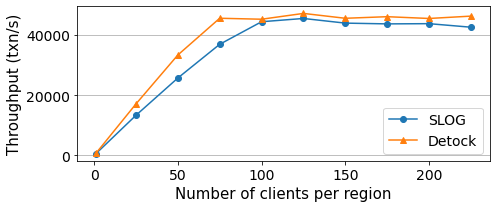

In [7]:
pivot_values = "throughput"
pivot_columns = "config_name"
pivot_index = "clients"
pivoted = throughput_df.pivot(index=pivot_index, columns=pivot_columns, values=pivot_values).sort_index()
pivoted["clients"] = pivoted.index
pivoted.rename(columns={"baseline.conf": "SLOG", "ddr_ts.conf": "Detock"}, inplace=True)
pivoted.columns.name = ''

ax = pivoted.plot(x="clients", xlabel="Number of clients per region", ylabel='Throughput (txn/s)', rot=0, legend=False, figsize=(7,3))

markers = ["o", "^"]
for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])

ax.legend(ax.get_lines(), pivoted.columns)

plt.grid(axis='y')
plt.tight_layout()
plt.savefig('output/tpcc-throughput.pdf')

# Latency

# By regions

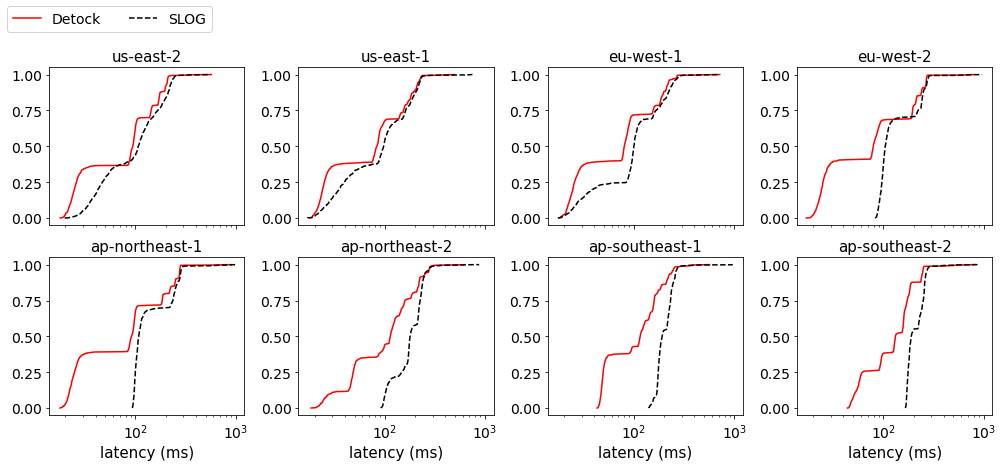

In [8]:
def plot_latency_per_region(sdf_dict):
    rows = 2
    cols = 4
    fig, ax = plt.subplots(rows, cols, figsize=(14, 6), sharex=True)
    regions = [
        "us-east-2",
        "us-east-1",
        "eu-west-1",
        "eu-west-2",
        "ap-northeast-1",
        "ap-northeast-2",
        "ap-southeast-1",
        "ap-southeast-2"
    ]
    for i in range(8):
        r, c = i // cols, i % cols
        ax[r, c].set_prop_cycle(cycler(linestyle=['-', '--']) + cycler(color='rk'))
        for label, sdf in sdf_dict.items():
            plot_cdf(
                collect_col(sdf.where(col("coordinator_region") == i), "latency"),
                ax=ax[r, c],
                label=label if i == 0 else '_nolegend_',
            )

        ax[r, c].set_title(f"{regions[i]}")
        if r == rows - 1:
            ax[r, c].set_xlabel("latency (ms)")

    return fig, ax

index_sdf = get_index(spark, PREFIX)

latency_sdf = latency(spark, map(
        lambda r : r.prefix,
        index_sdf.select("prefix").collect()
    ))\
    .withColumn(
        "coordinator_region",
        (col("coordinator") / 3).cast(T.IntegerType())
    )\
    .join(index_sdf, on="prefix")\
    .orderBy("clients")\
    .cache()

CLIENTS = 100

baseline_sdf = latency_sdf.where((col("config_name") == "baseline.conf") & (col("clients") == CLIENTS)).cache()
ddr_ts_sdf = latency_sdf.where((col("config_name") == "ddr_ts.conf") & (col("clients") == CLIENTS)).cache()

MH_FILTER = F.size("replicas") > 1

fig, _ = plot_latency_per_region({
    "Detock": ddr_ts_sdf.where(MH_FILTER),
    "SLOG": baseline_sdf.where(MH_FILTER),
})

fig.legend(bbox_to_anchor=(0, 1, 1, 0), loc='lower left', ncol=2)
fig.tight_layout()
fig.savefig('output/tpcc-cdf.pdf', bbox_inches='tight')

# Throughput & Latency

In [ ]:
IGNORE_CACHE = False

percentile_cols = [
    F.percentile_approx("latency", 0.5).alias("percentile_50"),
    F.percentile_approx("latency", 0.90).alias("percentile_90"),
    F.percentile_approx("latency", 0.95).alias("percentile_95"),
    F.percentile_approx("latency", 0.99).alias("percentile_99"),
]

baseline_pct = from_cache_or_compute(
    f'{PREFIX}/baseline_latency_pct.parquet',
    lambda: latency_sdf.where((col("config_name") == "baseline.conf"))\
        .groupBy("clients")\
        .agg(*percentile_cols)\
        .toPandas(),
    ignore_cache=IGNORE_CACHE,
)

ddr_ts_pct = from_cache_or_compute(
    f'{PREFIX}/ddr_ts_latency_pct.parquet',
    lambda: latency_sdf.where((col("config_name") == "ddr_ts.conf"))\
        .groupBy("clients")\
        .agg(*percentile_cols)\
        .toPandas(),
    ignore_cache=IGNORE_CACHE,
)

latency_pct_df = pd.concat([
    baseline_pct.assign(config_name="baseline.conf"),
    ddr_ts_pct.assign(config_name="ddr_ts.conf")
])

throughput_latency_df = throughput_df[["config_name", "clients", "throughput"]].merge(
    latency_pct_df,
    on=["config_name", "clients"]
).sort_values("clients")
throughput_latency_df.sort_values(["config_name", "throughput"])

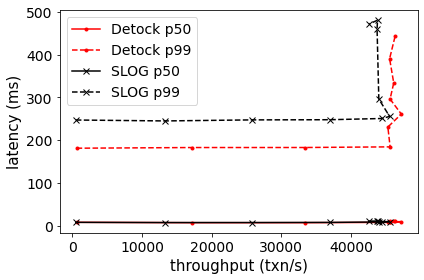

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
config_names = ["ddr_ts.conf", "baseline.conf"]
config_to_label = {
    'baseline.conf': 'SLOG',
    'ddr_only.conf': 'Detock (without Opportunistic Ordering)',
    'ddr_ts.conf': 'Detock'
}

ax.set_prop_cycle((cycler(marker=['.', 'x']) + cycler(color='rk')) * cycler(linestyle=['-', '--']))

for config in config_names:
    label = config_to_label[config]
    throughput_latency_df[throughput_latency_df.config_name == config].plot(x="throughput", y="percentile_50", label=f"{label} p50", ax=ax)
    throughput_latency_df[throughput_latency_df.config_name == config].plot(x="throughput", y="percentile_99", label=f"{label} p99", ax=ax)

ax.set_ylabel("latency (ms)")
ax.set_xlabel("throughput (txn/s)")
fig.tight_layout()
fig.savefig('output/tpcc-throughput-latency.pdf')